In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import time
from scipy.stats import multivariate_normal

from RCT_experiment import *
from Bayes_linear_regression import *
from plotting_functions import *
from MCMC_Bayesian_update import *
from utils import *


/Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)
show_plots = True

n_host_and_mirror = 1000
X0 = np.random.randint(0, 2, size=n_host_and_mirror)
X1 = np.random.normal(size=n_host_and_mirror)
x_distributions = {0: X0, 1: X1}

p_assigned_to_host = lambda X_1, X_2, T, eps: sigmoid(1 + X_1 - X_2 + T + eps)
p_assigned_to_cand2 = lambda X_1, X_2, T, eps: sigmoid(1 - 3*X_1 + eps)
X_rct, T_rct = generate_rct(n_host_and_mirror, x_distributions)

data_host, data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2)
design_data_host = generate_design_matrix(data_host, power_x=1, power_x_t=1)
design_data_mirror = generate_design_matrix(data_mirror, power_x=1, power_x_t=1)

n_pre_cand2 = 500
pre_X_cand2, pre_T_cand2 = generate_rct(n_pre_cand2, x_distributions)
data_cand2 = generate_host2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, n_cand2=100)
design_data_cand2 = generate_design_matrix(data_cand2, power_x=1, power_x_t=1)

outcome_function = lambda X, T, eps: 1 + 0 * X[:,0] + 1 * X[:,1] + 1 * T - 0* X[:,1]*T + eps 
std_true_y = 0.0 # Standard deviation for the true Y
design_data_host = add_outcome(design_data_host, outcome_function, std_true_y)
design_data_mirror = add_outcome(design_data_mirror, outcome_function, std_true_y)
design_data_cand2 = add_outcome(design_data_cand2, outcome_function, std_true_y)

### 2. Simulating from prior and plotting
Note: I don't think this is the right way to compare if our estimates are getting better but it will do for now

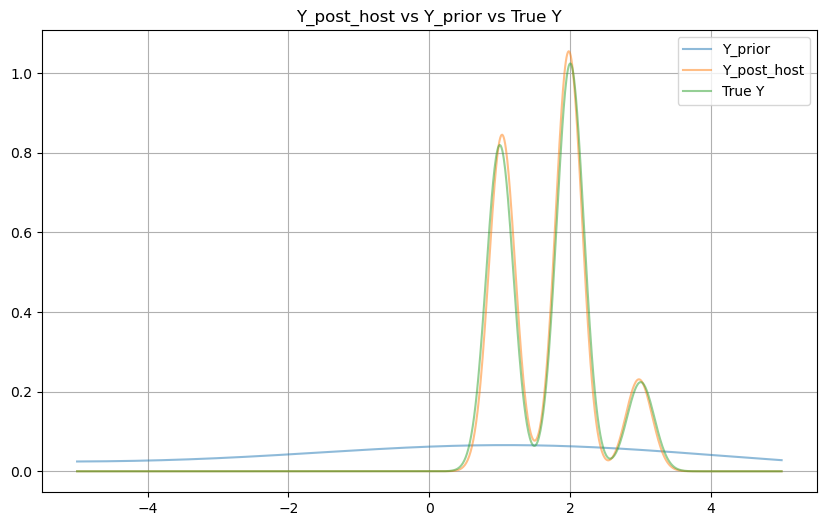

In [3]:
# Initialize prior parameters
# post_mean = np.array([-10, 0.5, 2, -10, 0, -4])
# a = beta_post_host_vec
post_mean = np.array([1, 0.5, 2, -12, 0, -6])
beta_0, sigma_0_sq = post_mean, 1
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq}
bayes_reg = BayesianLinearRegression(prior_hyperparameters)

### Bayesian update through host dataset
X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
post_host_parameters = bayes_reg.fit(X_host, Y_host)

# Generate Y_prior
sigma_prior = 1  # Standard deviation for Y_prior
Y_prior = np.dot(X_host, beta_0) + np.random.normal(0, sigma_prior, len(X_host))

# Generate Y_post_host
beta_post_host_vec = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']
Y_post_host = np.dot(X_host, beta_post_host_vec) + np.random.normal(0, 0.01, len(X_host))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_prior, Y_post_host, design_data_host['Y'], 
                names = ['Y_prior', 'Y_post_host', 'True Y'], 
                title = 'Y_post_host vs Y_prior vs True Y')


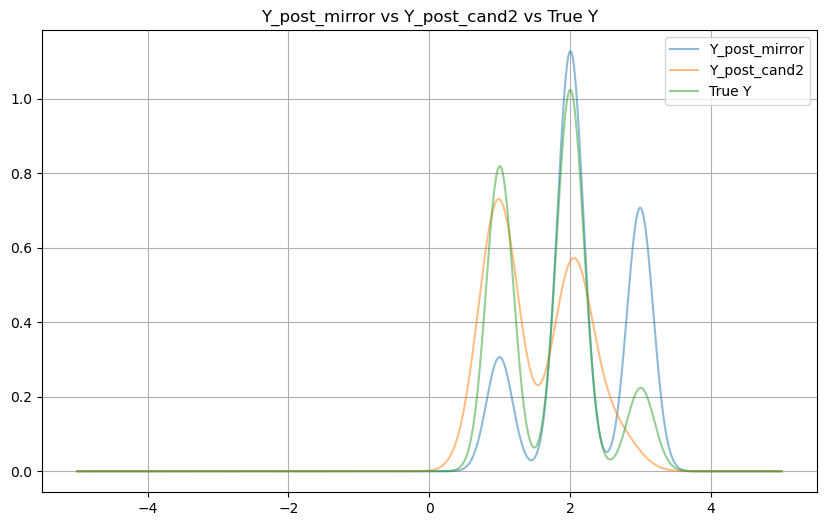

In [4]:
### Bayesian update through candidate datasets
sigma_cand = 1
prior_hyperparameters_cand = {'beta_0': beta_post_host_vec, 'sigma_0_sq': sigma_cand}

## With candidate = mirror dataset
bayes_reg_mirror = BayesianLinearRegression(prior_hyperparameters_cand)
X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
post_mirror_parameters = bayes_reg_mirror.fit(X_mirror, Y_mirror)

# Generate Y_post_mirror
post_mirror_mean = post_mirror_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_mirror = np.dot(X_mirror, post_mirror_mean) + np.random.normal(0, 0.01, len(X_mirror))  # Assuming standard deviation for Y_post_host is 1

## With candidate = cand2 dataset
bayes_reg_cand2 = BayesianLinearRegression(prior_hyperparameters_cand)
X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']
post_cand2_parameters = bayes_reg_cand2.fit(X_cand2, Y_cand2)

# Generate Y_post_cand2
post_cand2_mean = post_cand2_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_cand2 = np.dot(X_cand2, post_cand2_mean) + np.random.normal(0, 0.01, len(X_cand2))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_post_mirror, Y_post_cand2, design_data_host['Y'],
                names = ['Y_post_mirror', 'Y_post_cand2', 'True Y'], 
                title = 'Y_post_mirror vs Y_post_cand2 vs True Y')


In [5]:
#Number of samples used to estimate outer expectation
n_samples_for_expectation = 200
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
# Incorporating sqrt constraint into MCMC samples
n_mcmc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

warmup_steps = 500
max_tree_depth = 7
sigma_rand_error = 1

X_torch = torch.tensor(X_host.values)
Y_torch = torch.tensor(Y_host.values)

## Bayesian update using the host dataset
mcmc_host = MCMC_Bayesian_update(X_torch =X_torch, Y_torch = Y_torch, model =model_normal,
            mu_0= beta_0, sigma_prior = sigma_prior, sigma_rand_error = sigma_rand_error,
            sigma_rand_error_fixed = True,n_mcmc = n_mcmc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
mcmc_host.summary()

beta_post_host = pd.DataFrame(mcmc_host.get_samples())

#Shuffling to remove any dependence between adjacent samples
beta_post_host = beta_post_host.sample(frac = 1)

beta_post_host.head()
# We delete the column with the std
beta_post_host_without_std = beta_post_host.iloc[:, :-1] 

Sample: 100%|██████████| 3700/3700 [00:24, 151.90it/s, step size=4.21e-01, acc. prob=0.900]

Inference ran for 0.41 minutes

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0      1.07      0.08      1.07      0.95      1.20   1722.86      1.00
    beta_1      0.92      0.18      0.92      0.63      1.20   2056.95      1.00
    beta_2      0.04      0.07      0.04     -0.07      0.15   1742.54      1.00
    beta_3      0.86      0.11      0.86      0.69      1.04   1638.35      1.00
    beta_4      0.15      0.24      0.16     -0.25      0.53   2074.66      1.00
    beta_5     -0.06      0.10     -0.06     -0.22      0.10   1749.26      1.00

Number of divergences: 0


### We should have that the mean of beta_post_host is beta_post_host_vec here

In [6]:
X_host.shape

(434, 6)

In [7]:
[1, 0, 1, 1, 0, 0]

[1, 0, 1, 1, 0, 0]

In [8]:
beta_post_host_vec

array([ 1.0307509 ,  0.97346769,  0.01652091,  0.94203864,  0.03052598,
       -0.03201494])

In [9]:
beta_post_host.describe()

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5
count,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000
mean,1.074317,0.919294,0.038769,0.857126,0.152997,-0.063981
std,0.076667,0.176575,0.069258,0.107715,0.238310,0.098597
min,0.790442,0.351541,-0.185992,0.413314,-0.827410,-0.401372
25%,1.024366,0.798566,-0.006903,0.784895,-0.007615,-0.128909
50%,1.074547,0.917995,0.037748,0.858436,0.155510,-0.064822
75%,1.124337,1.039014,0.086389,0.927152,0.312011,0.003321
max,1.367659,1.564595,0.259024,1.224184,0.954478,0.284514


### 3. Calculating EIG

For the mirror dataset

First, we calculate EIG using samples by getting the model predictions and putting them in the correct form

In [10]:
X_mirror_arr = X_mirror.values
Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host, X_mirror_arr)

pred_list_mirror = predictions_in_EIG_obs_form(Y_pred_mirror,n_samples_for_expectation,m_samples_for_expectation)

In [11]:
sigma_rand_error

1

In [37]:
compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)

4.403319932806198

Now to calculate for the causal

In [13]:
from functools import partial
from MCMC_Bayesian_update import retun_causal_samp_func_linear


In [18]:
sample_func = retun_causal_samp_func_linear(X=X_torch,Y=Y_torch,causal_param_first_index=3,mu_0=beta_0,sigma_prior = sigma_prior,
                                            sigma_rand_error = sigma_rand_error,sigma_rand_error_fixed = True,warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
pred_func = lambda beta: beta @ (X_mirror).T

In [23]:
pred_in_causal_form = predictions_in_EIG_causal_form(pred_func, theta_samples=beta_post_host.values[:40], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)

Sample: 100%|██████████| 600/600 [00:01, 397.45it/s, step size=6.76e-01, acc. prob=0.915]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 398.66it/s, step size=6.38e-01, acc. prob=0.934]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 385.05it/s, step size=6.39e-01, acc. prob=0.925]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 407.44it/s, step size=8.35e-01, acc. prob=0.889]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 410.17it/s, step size=7.31e-01, acc. prob=0.900]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 393.34it/s, step size=7.12e-01, acc. prob=0.919]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 394.90it/s, step size=7.28e-01, acc. prob=0.906]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 408.87it/s, step size=7.78e-01, acc. prob=0.919]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 396.45it/s, step size=7.19e-01, acc. prob=0.925]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 398.61it/s, step size=6.09e-01, acc. prob=0.935]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 402.13it/s, step size=6.57e-01, acc. prob=0.912]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 392.22it/s, step size=7.29e-01, acc. prob=0.911]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 395.60it/s, step size=7.35e-01, acc. prob=0.893]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 382.91it/s, step size=7.60e-01, acc. prob=0.933]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 401.23it/s, step size=7.61e-01, acc. prob=0.906]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 397.94it/s, step size=6.76e-01, acc. prob=0.908]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 420.25it/s, step size=7.05e-01, acc. prob=0.921]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 430.65it/s, step size=7.59e-01, acc. prob=0.917]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 421.28it/s, step size=8.61e-01, acc. prob=0.892]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 404.53it/s, step size=6.85e-01, acc. prob=0.925]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 411.19it/s, step size=6.67e-01, acc. prob=0.916]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 412.88it/s, step size=7.00e-01, acc. prob=0.933]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 418.62it/s, step size=7.98e-01, acc. prob=0.892]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 414.79it/s, step size=7.96e-01, acc. prob=0.911]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 409.63it/s, step size=7.20e-01, acc. prob=0.905]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 424.94it/s, step size=8.40e-01, acc. prob=0.875]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 393.81it/s, step size=6.74e-01, acc. prob=0.915]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 388.94it/s, step size=6.82e-01, acc. prob=0.921]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 414.52it/s, step size=8.85e-01, acc. prob=0.875]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 431.87it/s, step size=7.50e-01, acc. prob=0.902]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 398.67it/s, step size=7.86e-01, acc. prob=0.900]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 406.53it/s, step size=7.71e-01, acc. prob=0.922]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 404.98it/s, step size=8.98e-01, acc. prob=0.870]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 401.18it/s, step size=6.41e-01, acc. prob=0.935]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 424.82it/s, step size=8.60e-01, acc. prob=0.876]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 409.55it/s, step size=7.37e-01, acc. prob=0.920]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 400.98it/s, step size=6.61e-01, acc. prob=0.942]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 419.90it/s, step size=7.98e-01, acc. prob=0.884]


Inference ran for 0.02 minutes


Sample: 100%|██████████| 600/600 [00:01, 399.97it/s, step size=8.53e-01, acc. prob=0.899]


Inference ran for 0.03 minutes


Sample: 100%|██████████| 600/600 [00:01, 410.37it/s, step size=7.88e-01, acc. prob=0.926]

Inference ran for 0.02 minutes


In [54]:
compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form, sigma_rand_error)

7.175989083630952

Now, trying to calculate in closed form

In [45]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)

32.060689006438125

In [46]:
compute_EIG_causal_closed_form(X_mirror_arr, cov_matrix_post_host,sigma_rand_error, 3)

16.029123985027397

For the cand2 dataset

In [56]:
X_cand2_arr = X_cand2.values
Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host, X_cand2_arr)

pred_list_cand2 = predictions_in_EIG_obs_form(Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation)

NameError: name 'samples_in_EIG_form' is not defined

In [55]:
compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

NameError: name 'pred_list_cand2' is not defined

Now, trying to calculate in closed form

In [ ]:
compute_EIG_obs_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error)

12.038579085422892

In [ ]:
compute_EIG_causal_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error, 3)

5.662853036225751